# GPU 설정

In [1]:
## GPU 사용시, GPU를 먼저 선택 후, 아래 코드(구글 드라이브 마운팅) 실행해야함!!!
# # 초기 1회 실행
from google.colab import drive
drive.mount('/content/drive')
# 코드 실행

Mounted at /content/drive


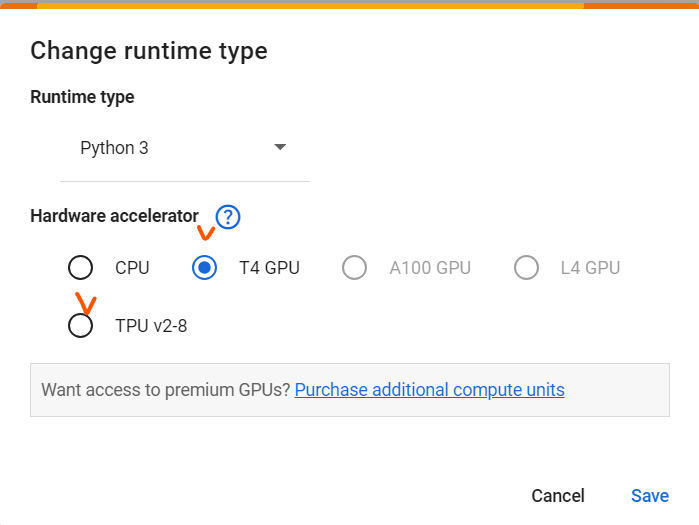

In [2]:
import torch
## Google Colab에서 GPU 사용 설정, gpu가 있으면 gpu 사용, 아니면 cpu  사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
## 사용 가능한 GPU가 몇 개인지 확인
gpu_count = torch.cuda.device_count()

## 각 GPU에 대한 정보 출력
for i in range(gpu_count):
    gpu_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {gpu_name}")
    print(f"총 멀티프로세서 수: {torch.cuda.get_device_capability(i)}")  # Compute Capability 확인
    print("멀티프로세서 =/= 코어수 ")

GPU 0: Tesla T4
총 멀티프로세서 수: (7, 5)
멀티프로세서 =/= 코어수 


In [ ]:
# 초기 1회 실행
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## 필요 패키지 설치 및 import
import importlib.util
import subprocess
import sys
def install_and_import(packages):
    for pkg in packages:
        package = pkg
        try:
            importlib.util.find_spec(package)
            print(f"{package} is already installed.")
        except ImportError:
            # 모듈이 설치되어 있지 않은 경우 설치시도
            print(f"{package} is not installed. Installing...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            subprocess.check_call(["conda", "install", package, "-y"])

            # 설치 후 다시 임포트를 시도
            importlib.import_module(package)
            print(f"{package} has been successfully installed.")

        # finally:
        #     globals()[package] = importlib.import_module(package)
        except Exception as e:
            # 설치 중 예외가 발생한 경우, 에러 메시지를 출력
            print(f"An error occurred while installing {package}: {str(e)}")

# 예시 사용법
# install_and_import(['hiddenlayer', ''])


In [5]:
ppath = '/content/drive/MyDrive/aibootcamp/딥러닝/data'

In [6]:
## 필요 모듈 임포트
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


## 데이터 읽기

## 데이터 확인

In [12]:
train_subset = torch.load(ppath + '/train_subset.pth', weights_only=False) # cifar - 10, 5000개
test_subset = torch.load(ppath + '/test_subset.pth', weights_only=False) # cifar - 10, 1000개

- https://www.cs.toronto.edu/~kriz/cifar.html
- 10개의 예측 클래스 label

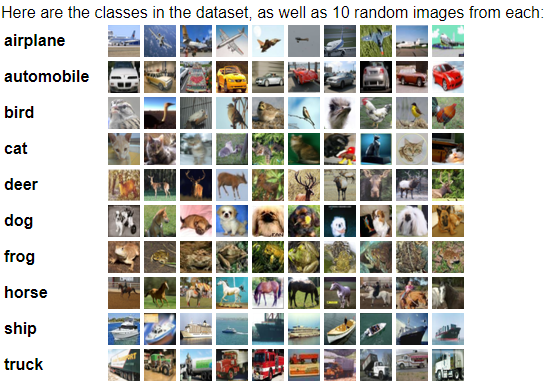

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random

## 첫 번째 데이터 샘플의 이미지와 레이블
image, label = train_subset[0]

## 데이터 차원 출력 (이미지의 차원과 데이터 타입)
print("Image shape: ", image.shape)  # (채널, 높이, 너비) 형태로 출력됨
print(f"Label: {label}")

Image shape:  torch.Size([3, 224, 224])
Label: 7


Randomly selected label: 0


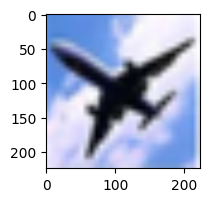

In [16]:
## 무작위 이미지 데이터 확인 및 시각화
ii = random.randint(0, len(train_subset) - 1)  # 무작위로 인덱스 선택
image, label = train_subset[ii]
print("Randomly selected label:", label)

## 정규화 해제 및 시각화
image = image / 2 + 0.5  # 정규화 해제 (Normalize에 따라 설정된 값을 원래대로 돌림)
np_image = image.numpy()  # Tensor를 NumPy 배열로 변환
plt.figure(figsize = (2, 2))
plt.imshow(np.transpose(np_image, (1, 2, 0)))  # (채널, 높이, 너비) -> (높이, 너비, 채널)로 변환
plt.show()

## 파이토치 랜덤시드

In [17]:
## 재현을 위한 랜덤 시드 고정...


## 랜덤 시드 고정 함수 정의
def set_seed(seed):
   ## 시드 고정
  random.seed(seed)                 # Python 기본 랜덤 시드 고정
  np.random.seed(seed)           # NumPy 랜덤 시드 고정
  torch.manual_seed(seed)     # PyTorch CPU 시드 고정

  ## GPU가 있는 경우 시드 고정, GPU 연산에서 사용되는 난수 생성기의 시드를 고정
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)  # 모든 GPU에서 시드 고정

  ## CuDNN 설정 (GPU 사용 시), CuDNN 라이브러리의 비결정적 연산을 방지,  동일한 결과를 얻기 위한 설정..
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


## 시드 고정
set_seed(123)  # 원하는 시드 값 설정


# 전이 학습

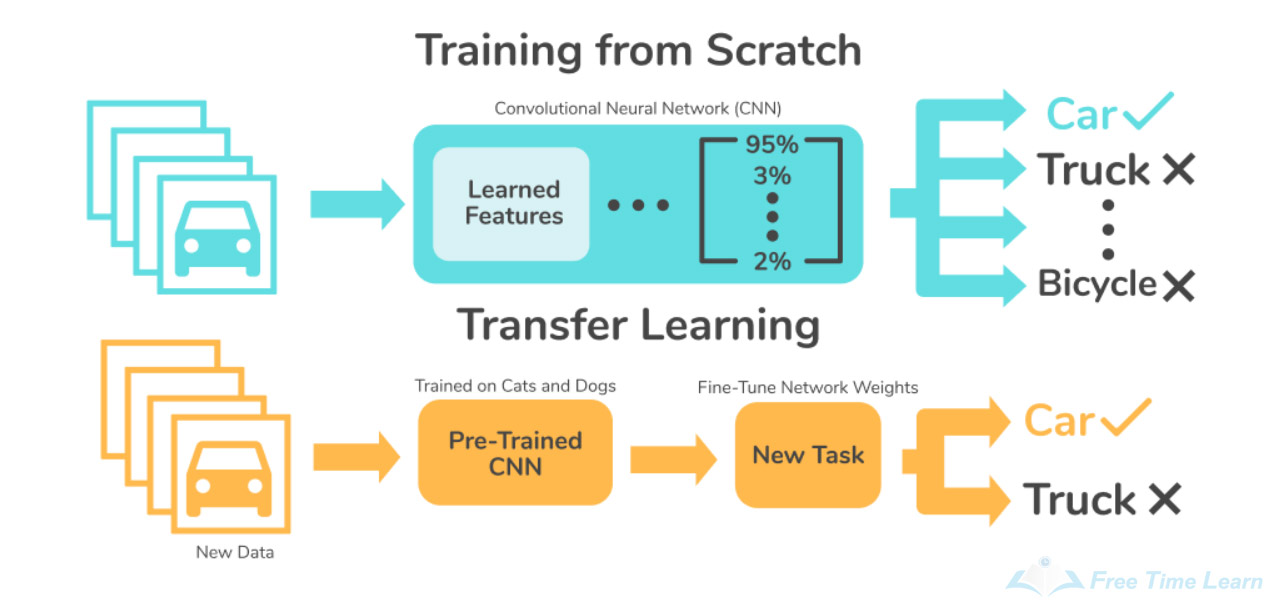

1. 전이 학습(Transfer Learning)
- 전이 학습은 사전 학습된 모델(가중치)을 가져와서 새로운 데이터에 맞게 일부 층을 학습하는 방법
- 일반적으로 모델의 **기존 가중치(특히, 저수준 및 중간 특징을 학습하는 초기 층)**를 유지
-  마지막 출력 층만 업데이트해서 새로운 데이터에 맞게 학습

2. 전이학습과정  
  - 2.1. 마지막 레이어 수정
    - 사전 학습된 모델의 마지막 레이어를 새로운 데이터셋의 클래스 개수에 맞게 수정
    - ImageNet 데이터셋에서 학습된 ResNet은 1000개의 클래스를 예측하도록 설정되어 있음..
    - 따라서 새로운 데이터셋에 맞게 출력 레이어를 교체해야 함

  - 2.2. 특정 레이어 동결(Fine-tuning)
    - 기존의 모델의 가중치를 유지하고 싶은 경우에, 특정 레이어를 **동결(freeze)**하면 해당 레이어의 가중치는 고정되고, 학습되지 않음
    - 이렇게 하면 학습 속도가 빨라지고, 모델의 가중치를 유지할 수 있음

  - 2.3. 모델 학습
    - 새로운 데이터셋을 이용해 모델을 학습하면 됨
    - 마지막 레이어만 학습..


### 전이학습 과정

- torchvision.models 모듈 확인
- 사전 학습된 모델 다운로드
- 전이 학습을 위해 모통 모델의 마지막 층을 수정

### 모델 다운로드

In [ ]:
import torch
import torchvision.models as models

## 개별 모델 다운받기
# # VGGNet 다운로드
# vgg = models.vgg16(pretrained=True)

# # ResNet 다운로드
# resnet = models.resnet50(pretrained=True)

# # RegNet 다운로드
# regnet = models.regnet_y_800mf(pretrained=True)

# # 모델을 평가 모드로 전환
# vgg.eval()
# resnet.eval()
# regnet.eval()


## 2. 사전학습 모델 불러오기

In [ ]:
## 2. 사전 학습된 모델 불러오기 (ResNet, VGGNet, RegNet)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## ResNet 불러오기
resnet = models.resnet18(pretrained = True)
## 마지막 레이어 추가!!!
resnet.fc = nn.Linear(resnet.fc.in_features, 10)  # CIFAR-10은 10개의 클래스
resnet = resnet.to(device)


## VGGNet 불러오기
vgg = models.vgg16(pretrained = True)
## 마지막 레이어 추가!!!
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 10)
vgg = vgg.to(device)


## RegNet 불러오기
regnet = models.regnet_y_400mf(pretrained = True)
## 마지막 레이어 추가!!!
regnet.fc = nn.Linear(regnet.fc.in_features, 10)
regnet = regnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 223MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

 ## 3. 모델 학습 및 평가 함수 정의

In [ ]:
## 학습 함수
def train_model(model, optimizer, train_loader, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):

        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

## 평가 함수
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f} %")
    return accuracy

In [ ]:
## 평가 함수 정의
criterion = nn.CrossEntropyLoss() # 사용은 안함..

## 4. 각 모델 학습 및 평가

### 데이터 로더

In [ ]:
from torch.utils.data import DataLoader, Subset

## DataLoader 설정
train_loader = DataLoader(train_subset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_subset, batch_size = 32, shuffle = False)

### 마지막 레이어 학습
- 보통 에폭이 5~ 10 정도..
- 꽤....오래 걸림

In [ ]:
## ResNet 학습 및 평가
print("Training ResNet")
optimizer_resnet = optim.Adam(resnet.fc.parameters(), lr=0.001)
train_model(resnet, optimizer_resnet, train_loader, num_epochs = 5)
resnet_accuracy = evaluate_model(resnet, test_loader)


Training ResNet
Epoch [1/5], Loss: 1.4436
Epoch [2/5], Loss: 0.8812
Epoch [3/5], Loss: 0.7602
Epoch [4/5], Loss: 0.6901
Epoch [5/5], Loss: 0.6480
Test Accuracy: 74.80 %


In [ ]:
## VGGNet 학습 및 평가
print("Training VGGNet")
optimizer_vgg = optim.Adam(vgg.classifier.parameters(), lr=0.001)
train_model(vgg, optimizer_vgg, train_loader, num_epochs=5)
vgg_accuracy = evaluate_model(vgg, test_loader)


Training VGGNet
Epoch [1/5], Loss: 1.1500
Epoch [2/5], Loss: 0.6483
Epoch [3/5], Loss: 0.4550
Epoch [4/5], Loss: 0.5106
Epoch [5/5], Loss: 0.4190
Test Accuracy: 75.40 %


In [ ]:
## RegNet 학습 및 평가
print("Training RegNet")
optimizer_regnet = optim.Adam(regnet.fc.parameters(), lr=0.001)
train_model(regnet, optimizer_regnet, train_loader, num_epochs=5)
regnet_accuracy = evaluate_model(regnet, test_loader)


Training RegNet
Epoch [1/5], Loss: 1.5213
Epoch [2/5], Loss: 0.9356
Epoch [3/5], Loss: 0.8028
Epoch [4/5], Loss: 0.7364
Epoch [5/5], Loss: 0.6904
Test Accuracy: 75.60 %


## 5. 모델 비교

In [ ]:
print("Model Comparison:")
print(" ")
print(f"ResNet Test Accuracy: {resnet_accuracy:.4f} %")
print(f"VGGNet Test Accuracy: {vgg_accuracy:.4f} %")
print(f"RegNet Test Accuracy: {regnet_accuracy:.4f} %")

Model Comparison:
 
ResNet Test Accuracy: 74.8000 %
VGGNet Test Accuracy: 75.4000 %
RegNet Test Accuracy: 75.6000 %


In [ ]:
# 원래 성능은..(imagenet 기준)
# ResNet >= RegNet   > VGG

In [ ]:
# EOS